In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad


cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


NVIDIA A30
(872, 4500, 14) (872,)


# Cycle GAN

In [2]:
# Improved Residual Block for Time Series
class TimeSeriesResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.norm1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.norm2 = nn.BatchNorm1d(channels)
        self.activation = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        residual = x
        out = self.activation(self.norm1(self.conv1(x)))
        out = self.dropout(out)
        out = self.norm2(self.conv2(out))
        return self.activation(out + residual)

# Enhanced Generator for Time Series
class TimeSeriesGenerator(nn.Module):
    def __init__(self, input_channels=14, hidden_dim=128, n_residual_blocks=6):
        super().__init__()
        
        # Initial convolution
        self.initial = nn.Sequential(
            nn.Conv1d(input_channels, hidden_dim//2, kernel_size=7, padding=3),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(inplace=True)
        )
        
        # Downsampling layers
        self.down1 = nn.Sequential(
            nn.Conv1d(hidden_dim//2, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        self.down2 = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(hidden_dim*2),
            nn.ReLU(inplace=True)
        )
        
        # Residual blocks
        self.residual_blocks = nn.ModuleList([
            TimeSeriesResidualBlock(hidden_dim*2) for _ in range(n_residual_blocks)
        ])
        
        # Upsampling layers
        self.up1 = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim*2, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim, hidden_dim//2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(inplace=True)
        )
        
        # Final output layer
        self.final = nn.Sequential(
            nn.Conv1d(hidden_dim//2, input_channels, kernel_size=7, padding=3),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)
        
        for block in self.residual_blocks:
            x = block(x)
            
        x = self.up1(x)
        x = self.up2(x)
        x = self.final(x)
        
        return x

# Enhanced Discriminator for Time Series
class TimeSeriesDiscriminator(nn.Module):
    def __init__(self, input_channels=14, hidden_dim=64):
        super().__init__()
        
        self.model = nn.Sequential(
            # First layer - no normalization
            nn.Conv1d(input_channels, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Second layer
            nn.Conv1d(hidden_dim, hidden_dim*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Third layer
            nn.Conv1d(hidden_dim*2, hidden_dim*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Fourth layer
            nn.Conv1d(hidden_dim*4, hidden_dim*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(hidden_dim*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final layer
            nn.Conv1d(hidden_dim*8, 1, kernel_size=4, padding=1),
            nn.AdaptiveAvgPool1d(1)  # Global average pooling
        )
        
    def forward(self, x):
        return self.model(x).squeeze()

# Data preprocessing and normalization
class TimeSeriesNormalizer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.fitted = False
        
    def fit_transform(self, data):
        """
        data: shape (n_samples, seq_len, n_features)
        """
        original_shape = data.shape
        # Reshape to (n_samples * seq_len, n_features)
        data_reshaped = data.reshape(-1, data.shape[-1])
        
        # Fit and transform
        normalized_data = self.scaler.fit_transform(data_reshaped)
        self.fitted = True
        
        # Reshape back to original shape
        return normalized_data.reshape(original_shape)
    
    def transform(self, data):
        if not self.fitted:
            raise ValueError("Scaler not fitted yet!")
        
        original_shape = data.shape
        data_reshaped = data.reshape(-1, data.shape[-1])
        normalized_data = self.scaler.transform(data_reshaped)
        return normalized_data.reshape(original_shape)
    
    def inverse_transform(self, data):
        if not self.fitted:
            raise ValueError("Scaler not fitted yet!")
            
        original_shape = data.shape
        data_reshaped = data.reshape(-1, data.shape[-1])
        denormalized_data = self.scaler.inverse_transform(data_reshaped)
        return denormalized_data.reshape(original_shape)

# Enhanced CycleGAN training function
def train_cyclegan_timeseries_stable(normal_data, device, epochs=200, batch_size=8, lr=2e-4):
    """
    Enhanced CycleGAN training with improved stability
    """
    print(f"Training CycleGAN on data shape: {normal_data.shape}")
    
    # Normalize data
    normalizer = TimeSeriesNormalizer()
    normalized_data = normalizer.fit_transform(normal_data)
    
    # Split data into two domains
    mid_point = len(normalized_data) // 2
    domain_A = normalized_data[:mid_point]
    domain_B = normalized_data[mid_point:]
    
    # Convert to tensors
    tensor_A = torch.tensor(domain_A, dtype=torch.float32).permute(0, 2, 1)
    tensor_B = torch.tensor(domain_B, dtype=torch.float32).permute(0, 2, 1)
    
    dataset = TensorDataset(tensor_A, tensor_B)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize networks
    G_AB = TimeSeriesGenerator().to(device)
    G_BA = TimeSeriesGenerator().to(device)
    D_A = TimeSeriesDiscriminator().to(device)
    D_B = TimeSeriesDiscriminator().to(device)
    
    # **IMPROVED OPTIMIZERS** - Different learning rates for G and D
    optimizer_G = optim.Adam(
        list(G_AB.parameters()) + list(G_BA.parameters()),
        lr=lr, betas=(0.5, 0.999)
    )
    # Slower learning rate for discriminators to prevent collapse
    optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr/2, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr/2, betas=(0.5, 0.999))
    
    # **IMPROVED LOSS FUNCTIONS** - Use label smoothing
    def adversarial_loss_smooth(pred, target_is_real):
        if target_is_real:
            target = torch.ones_like(pred) * 0.9  # Label smoothing
        else:
            target = torch.zeros_like(pred) * 0.1  # Label smoothing
        return nn.MSELoss()(pred, target)
    
    cycle_loss = nn.L1Loss()
    identity_loss = nn.L1Loss()
    
    # Training history
    history = {
        'G_loss': [], 'D_A_loss': [], 'D_B_loss': [],
        'cycle_loss': [], 'identity_loss': []
    }
    
    print("Starting stable training...")
    for epoch in range(epochs):
        epoch_G_loss = 0
        epoch_D_A_loss = 0
        epoch_D_B_loss = 0
        epoch_cycle_loss = 0
        epoch_identity_loss = 0
        
        for i, (real_A, real_B) in enumerate(dataloader):
            real_A, real_B = real_A.to(device), real_B.to(device)
            
            # **TRAIN DISCRIMINATORS MORE FREQUENTLY**
            for _ in range(2):  # Train discriminators twice per generator update
                
                # ============ Train Discriminator A ============
                optimizer_D_A.zero_grad()
                
                # Generate fake samples
                fake_A = G_BA(real_B).detach()
                
                pred_real_A = D_A(real_A)
                pred_fake_A = D_A(fake_A)
                
                loss_D_real_A = adversarial_loss_smooth(pred_real_A, True)
                loss_D_fake_A = adversarial_loss_smooth(pred_fake_A, False)
                
                loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
                loss_D_A.backward()
                optimizer_D_A.step()
                
                # ============ Train Discriminator B ============
                optimizer_D_B.zero_grad()
                
                fake_B = G_AB(real_A).detach()
                
                pred_real_B = D_B(real_B)
                pred_fake_B = D_B(fake_B)
                
                loss_D_real_B = adversarial_loss_smooth(pred_real_B, True)
                loss_D_fake_B = adversarial_loss_smooth(pred_fake_B, False)
                
                loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
                loss_D_B.backward()
                optimizer_D_B.step()
            
            # ============ Train Generators ============
            optimizer_G.zero_grad()
            
            # Identity loss (reduced weight)
            identity_B = G_AB(real_B)
            identity_A = G_BA(real_A)
            loss_identity = (identity_loss(identity_B, real_B) + 
                           identity_loss(identity_A, real_A)) * 2.0  # Reduced from 5.0
            
            # GAN loss
            fake_B = G_AB(real_A)
            fake_A = G_BA(real_B)
            
            pred_fake_B = D_B(fake_B)
            pred_fake_A = D_A(fake_A)
            
            loss_GAN_AB = adversarial_loss_smooth(pred_fake_B, True)
            loss_GAN_BA = adversarial_loss_smooth(pred_fake_A, True)
            
            # Cycle consistency loss
            recovered_A = G_BA(fake_B)
            recovered_B = G_AB(fake_A)
            loss_cycle = (cycle_loss(recovered_A, real_A) + 
                         cycle_loss(recovered_B, real_B)) * 10.0
            
            # Total generator loss
            loss_G = loss_GAN_AB + loss_GAN_BA + loss_cycle + loss_identity
            loss_G.backward()
            optimizer_G.step()
            
            # Accumulate losses
            epoch_G_loss += loss_G.item()
            epoch_D_A_loss += loss_D_A.item()
            epoch_D_B_loss += loss_D_B.item()
            epoch_cycle_loss += loss_cycle.item()
            epoch_identity_loss += loss_identity.item()
        
        # Average losses
        num_batches = len(dataloader)
        epoch_G_loss /= num_batches
        epoch_D_A_loss /= num_batches
        epoch_D_B_loss /= num_batches
        epoch_cycle_loss /= num_batches
        epoch_identity_loss /= num_batches
        
        # Store history
        history['G_loss'].append(epoch_G_loss)
        history['D_A_loss'].append(epoch_D_A_loss)
        history['D_B_loss'].append(epoch_D_B_loss)
        history['cycle_loss'].append(epoch_cycle_loss)
        history['identity_loss'].append(epoch_identity_loss)
        
        # Print progress and check for instability
        print(f"Epoch [{epoch+1}/{epochs}] - "
                f"G: {epoch_G_loss:.4f}, D_A: {epoch_D_A_loss:.4f}, D_B: {epoch_D_B_loss:.4f}, "
                f"Cycle: {epoch_cycle_loss:.4f}, Identity: {epoch_identity_loss:.4f}")
            
            # **STABILITY CHECK**
        if epoch_D_A_loss < 0.01 and epoch_D_B_loss < 0.01:
            print("Warning: Discriminator losses too low! Potential collapse detected.")
            # Optionally restart discriminators or adjust learning rates

    return G_AB, G_BA, normalizer, history

# Generate synthetic data
def generate_synthetic_data(generator, original_data, normalizer, device, num_samples=None):
    """
    Generate synthetic time series data
    """
    if num_samples is None:
        num_samples = len(original_data)
    
    generator.eval()
    synthetic_samples = []
    
    # Normalize original data
    normalized_data = normalizer.transform(original_data)
    
    with torch.no_grad():
        # Convert to tensor format (batch, channels, seq_len)
        tensor_data = torch.tensor(normalized_data, dtype=torch.float32).permute(0, 2, 1)
        
        # Generate in batches
        batch_size = 32
        for i in range(0, len(tensor_data), batch_size):
            batch = tensor_data[i:i+batch_size].to(device)
            synthetic_batch = generator(batch)
            synthetic_samples.append(synthetic_batch.cpu())
        
        # Concatenate all batches
        synthetic_tensor = torch.cat(synthetic_samples, dim=0)
        
        # Convert back to original format (batch, seq_len, channels)
        synthetic_normalized = synthetic_tensor.permute(0, 2, 1).numpy()
        
        # Denormalize
        synthetic_data = normalizer.inverse_transform(synthetic_normalized)
    
    # Return requested number of samples
    return synthetic_data[:num_samples]

# Plotting function
def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(history['G_loss'])
    axes[0, 0].set_title('Generator Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    
    axes[0, 1].plot(history['D_A_loss'], label='D_A')
    axes[0, 1].plot(history['D_B_loss'], label='D_B')
    axes[0, 1].set_title('Discriminator Losses')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    
    axes[1, 0].plot(history['cycle_loss'])
    axes[1, 0].set_title('Cycle Consistency Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    
    axes[1, 1].plot(history['identity_loss'])
    axes[1, 1].set_title('Identity Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    
    plt.tight_layout()
    plt.show()


# CycleGAN Training

Starting CycleGAN training for time series data...
Training CycleGAN on data shape: (690, 4500, 14)
Starting stable training...
Epoch [1/15] - G: 18.2983, D_A: 0.1271, D_B: 0.1603, Cycle: 14.2849, Identity: 2.9386
Epoch [2/15] - G: 13.9937, D_A: 0.0228, D_B: 0.0307, Cycle: 10.6105, Identity: 2.2607
Epoch [3/15] - G: 12.0038, D_A: 0.0210, D_B: 0.0205, Cycle: 8.8522, Identity: 1.9128
Epoch [4/15] - G: 10.8662, D_A: 0.0257, D_B: 0.0219, Cycle: 7.8535, Identity: 1.7616
Epoch [5/15] - G: 10.2201, D_A: 0.0264, D_B: 0.0197, Cycle: 7.2664, Identity: 1.7327
Epoch [6/15] - G: 9.9386, D_A: 0.0194, D_B: 0.0165, Cycle: 6.9178, Identity: 1.7513
Epoch [7/15] - G: 9.6193, D_A: 0.0112, D_B: 0.0121, Cycle: 6.5115, Identity: 1.7709
Epoch [8/15] - G: 9.4677, D_A: 0.0068, D_B: 0.0088, Cycle: 6.2553, Identity: 1.8082
Epoch [9/15] - G: 9.4237, D_A: 0.0047, D_B: 0.0077, Cycle: 6.1205, Identity: 1.8561
Epoch [10/15] - G: 9.3187, D_A: 0.0033, D_B: 0.0072, Cycle: 5.9688, Identity: 1.8693
Epoch [11/15] - G: 9.190

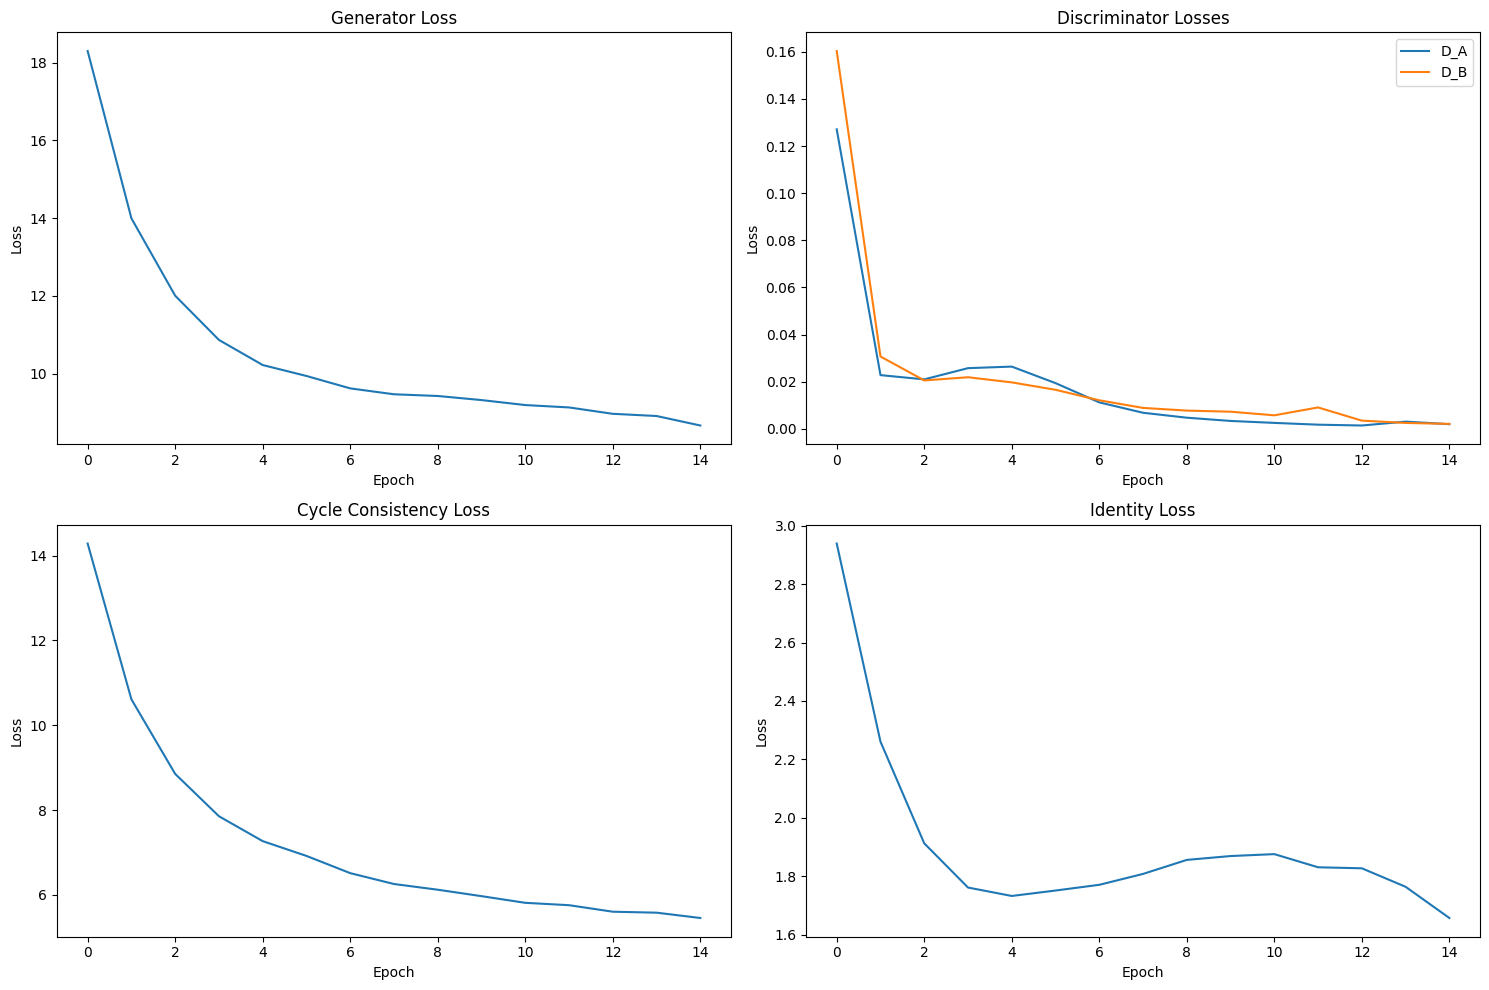

In [5]:

# Example usage
print("Starting CycleGAN training for time series data...")
G_AB, G_BA, normalizer, history = train_cyclegan_timeseries_stable(
    normal_data, 
    device, 
    epochs=15,  # Reduced for testing
    batch_size=32,  # Smaller batch size for your data
    lr=1e-4  # Slightly lower learning rate
)

# Plot training history
plot_training_history(history)





# Generate and Combine

In [11]:
# Generate synthetic data
print("Generating synthetic data...")
synthetic_data = generate_synthetic_data(G_AB, normal_data, normalizer, device, num_samples=len(normal_data))

print(f"Original data shape: {normal_data.shape}")
print(f"Synthetic data shape: {synthetic_data.shape}")

# Combine original and synthetic data
combine_data_normal = np.concatenate([normal_data, synthetic_data], axis=0)
combine_data_labels = np.concatenate([np.zeros(len(normal_data)), np.zeros(len(synthetic_data))], axis=0)

print(f"Combined data shape: {combine_data_normal.shape}")
print(f"Combined labels shape: {combine_data_labels.shape}")

Generating synthetic data...
Original data shape: (690, 4500, 14)
Synthetic data shape: (690, 4500, 14)
Combined data shape: (1380, 4500, 14)
Combined labels shape: (1380,)


# Processing: Mel Spec > Resizing > Feature Extraction

In [12]:
def resize_spectrogram(spectrogram, global_min=None, global_max=None):
    """
    Improved spectrogram processing with consistent normalization
    """
    # Use global min/max for consistent normalization across all spectrograms
    if global_min is not None and global_max is not None:
        spectrogram = (spectrogram - global_min) / (global_max - global_min + 1e-8)
    else:
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Clip to [0,1] and convert to uint8
    spectrogram = np.clip(spectrogram, 0, 1)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

def process_dataset_improved(data, sample_rate=1000):  # More reasonable sample rate
    """
    Improved dataset processing with better mel-spectrogram parameters
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    
    # Better mel-spectrogram parameters for sensor data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,          # Reasonable FFT size
        hop_length=256,     # 50% overlap
        win_length=512,
        window_fn=torch.hann_window
    ).to(device)
    
    # Load VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    # Compute global min/max for consistent normalization
    print("Computing global spectrogram statistics...")
    all_mels = []
    for i in range(min(100, num_samples)):  # Sample subset for statistics
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            all_mels.append(mel.cpu().numpy())
    
    all_mels = np.concatenate([mel.flatten() for mel in all_mels])
    global_min, global_max = np.percentile(all_mels, [1, 99])  # Use percentiles to avoid outliers
    
    print(f"Processing {num_samples} samples...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
            
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Use consistent normalization
            img = resize_spectrogram(mel, global_min, global_max)
            
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    
    return features

# Alternative: Multi-channel processing
def process_dataset_multichannel(data, sample_rate=1000):
    """
    Process multiple channels together to capture cross-channel relationships
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, 4096))  # Single feature vector per sample
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,
        hop_length=256,
        win_length=512
    ).to(device)
    
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    print(f"Processing {num_samples} samples with multi-channel approach...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
        
        # Combine multiple channels into RGB image
        channel_spectrograms = []
        for j in range(min(3, num_channels)):  # Use first 3 channels as RGB
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Normalize each channel spectrogram
            mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
            mel_resized = torch.nn.functional.interpolate(
                mel_norm.unsqueeze(0).unsqueeze(0), 
                size=(224, 224), 
                mode='bilinear'
            ).squeeze()
            channel_spectrograms.append(mel_resized.cpu().numpy())
        
        # Stack as RGB image
        if len(channel_spectrograms) == 1:
            rgb_img = np.stack([channel_spectrograms[0]] * 3, axis=0)
        elif len(channel_spectrograms) == 2:
            rgb_img = np.stack([channel_spectrograms[0], channel_spectrograms[1], channel_spectrograms[0]], axis=0)
        else:
            rgb_img = np.stack(channel_spectrograms[:3], axis=0)
        
        img_tensor = torch.tensor(rgb_img, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            feat = model(img_tensor)
        features[i, :] = feat.squeeze().cpu().numpy()
    
    return features

# AE Class

In [13]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.Tanh(),
            nn.Linear(8, 16), 
            nn.Tanh(),
            nn.Linear(16, 32), 
            nn.Tanh(),
            nn.Linear(32, 64), 
            nn.Tanh(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Add weight decay
    criterion = nn.MSELoss()  # Try MSE instead of L1

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            # Add noise for denoising autoencoder
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)  # Reconstruct clean from noisy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data, add_noise=True):
    """
    Compute reconstruction loss per sample (not per segment)
    data: shape (n_samples, n_channels, 4096)
    """
    model.eval()
    n_samples, n_channels, n_features = data.shape
    sample_errors = []
    
    # Flatten to (n_samples*n_channels, 4096) for batch processing
    x = torch.tensor(data.reshape(-1, n_features), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    
    all_errors = []
    criterion = torch.nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            
            if add_noise:
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                outputs = model(noisy_inputs)
            else:
                outputs = model(inputs)
            
            # Per-segment reconstruction error
            segment_errors = criterion(outputs, inputs).mean(dim=1)
            all_errors.extend(segment_errors.cpu().numpy())
    
    # Reshape back to (n_samples, n_channels) and aggregate per sample
    all_errors = np.array(all_errors).reshape(n_samples, n_channels)
    sample_errors = all_errors.mean(axis=1)  # Average across channels per sample
    
    return sample_errors

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    """
    X_test: shape (n_samples, 1, 4096) - already has channel dimension added
    y_test: shape (n_samples,)
    """
    # X_test already has shape (n_samples, 1, 4096) from your code
    # So we can directly compute reconstruction errors
    test_errors = compute_reconstruction_loss(model, X_test)
    
    # Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(test_errors.min(), test_errors.max(), 100):
        preds = (test_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Predict using best threshold
    test_preds = (test_errors > best_threshold).astype(int)

    # Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))


# Preprocessing

In [14]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_data_labels)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_normal_data = StandardScaler().fit_transform(combine_data_normal.reshape(-1, combine_data_normal.shape[-1])).reshape(combine_data_normal.shape)
scaled_original_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features_original = process_dataset_multichannel(scaled_original_data)
print("Features shape:", features_original.shape)
features_normal = process_dataset_multichannel(scaled_normal_data)
print("Features shape:", features_normal.shape)

Processing 872 samples with multi-channel approach...
Processed 0/872 samples
Processed 100/872 samples
Processed 200/872 samples
Processed 300/872 samples
Processed 400/872 samples
Processed 500/872 samples
Processed 600/872 samples
Processed 700/872 samples
Processed 800/872 samples
Features shape: (872, 4096)
Processing 1380 samples with multi-channel approach...
Processed 0/1380 samples
Processed 100/1380 samples
Processed 200/1380 samples
Processed 300/1380 samples
Processed 400/1380 samples
Processed 500/1380 samples
Processed 600/1380 samples
Processed 700/1380 samples
Processed 800/1380 samples
Processed 900/1380 samples
Processed 1000/1380 samples
Processed 1100/1380 samples
Processed 1200/1380 samples
Processed 1300/1380 samples
Features shape: (1380, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 1.191287
Epoch 2/15, Loss: 0.845560
Epoch 3/15, Loss: 0.599505
Epoch 4/15, Loss: 0.564802
Epoch 5/15, Loss: 0.560794
Epoch 6/15, Loss: 0.559465
Epoch 7/15, Loss: 0.558358
Epoch 8/15, Loss: 0.557909
Epoch 9/15, Loss: 0.557605
Epoch 10/15, Loss: 0.557220
Epoch 11/15, Loss: 0.557061
Epoch 12/15, Loss: 0.556885
Epoch 13/15, Loss: 0.556878
Epoch 14/15, Loss: 0.556585
Epoch 15/15, Loss: 0.556109
Best threshold: 0.5069120460086398, Best F1 Score: 0.6666666666666666


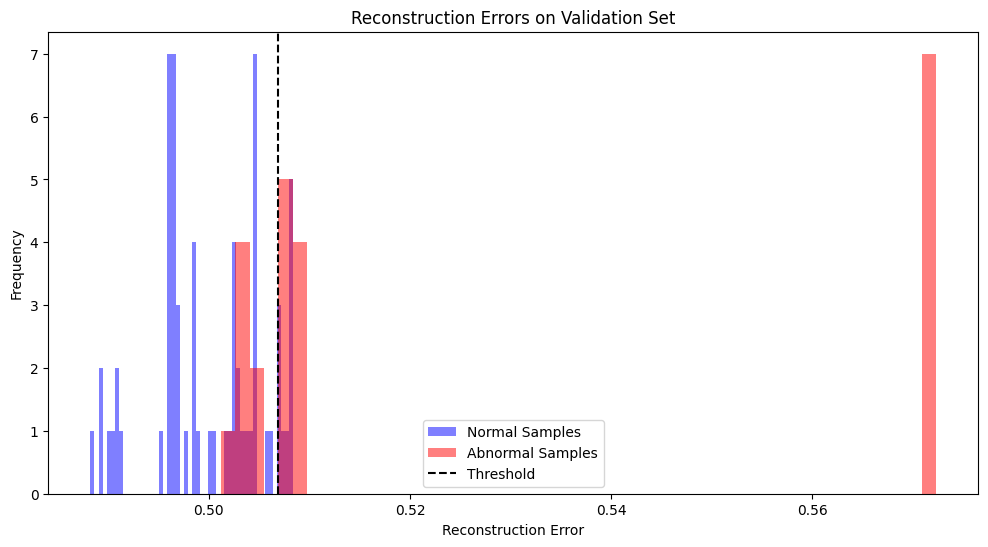

Best Threshold = 0.509568, Best F1 Score = 0.6000
Evaluation on Test Set:
Accuracy = 0.9090909090909091
Precision = 1.0
Recall = 0.42857142857142855
F1 Score = 0.6
Confusion Matrix:
 [[74  0]
 [ 8  6]]
Fold 2
Epoch 1/15, Loss: 1.191220
Epoch 2/15, Loss: 0.845473
Epoch 3/15, Loss: 0.598366
Epoch 4/15, Loss: 0.564748
Epoch 5/15, Loss: 0.560546
Epoch 6/15, Loss: 0.559522
Epoch 7/15, Loss: 0.558595
Epoch 8/15, Loss: 0.558248
Epoch 9/15, Loss: 0.557736
Epoch 10/15, Loss: 0.557769
Epoch 11/15, Loss: 0.557436
Epoch 12/15, Loss: 0.556902
Epoch 13/15, Loss: 0.556525
Epoch 14/15, Loss: 0.556246
Epoch 15/15, Loss: 0.556099
Best threshold: 0.501141223040494, Best F1 Score: 0.631578947368421


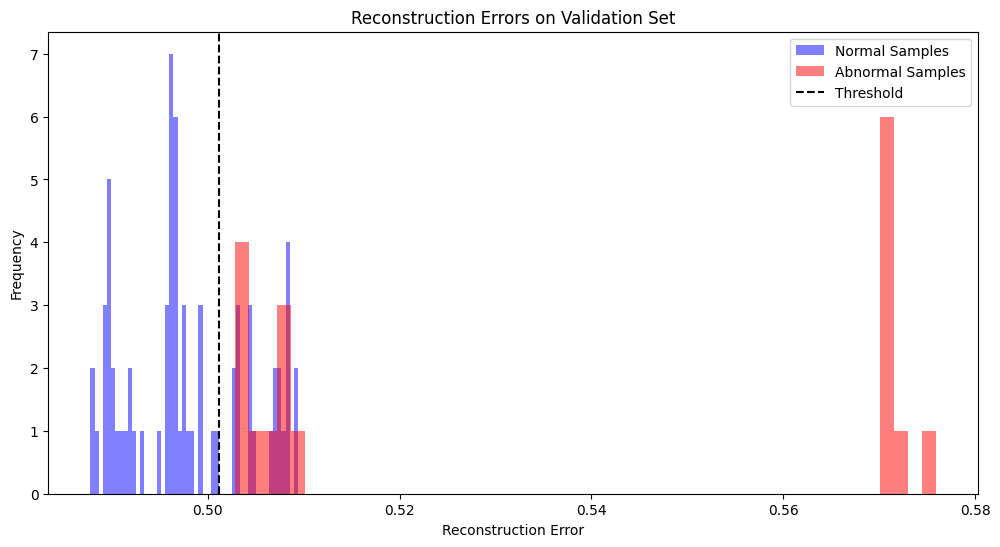

Best Threshold = 0.507885, Best F1 Score = 0.7692
Evaluation on Test Set:
Accuracy = 0.8977272727272727
Precision = 0.75
Recall = 0.7894736842105263
F1 Score = 0.7692307692307692
Confusion Matrix:
 [[64  5]
 [ 4 15]]
Fold 3
Epoch 1/15, Loss: 1.193991
Epoch 2/15, Loss: 0.846284
Epoch 3/15, Loss: 0.597655
Epoch 4/15, Loss: 0.564880
Epoch 5/15, Loss: 0.561162
Epoch 6/15, Loss: 0.559330
Epoch 7/15, Loss: 0.559222
Epoch 8/15, Loss: 0.558249
Epoch 9/15, Loss: 0.557437
Epoch 10/15, Loss: 0.557236
Epoch 11/15, Loss: 0.557068
Epoch 12/15, Loss: 0.557102
Epoch 13/15, Loss: 0.556140
Epoch 14/15, Loss: 0.556337
Epoch 15/15, Loss: 0.556301
Best threshold: 0.5039139721128676, Best F1 Score: 0.6046511627906976


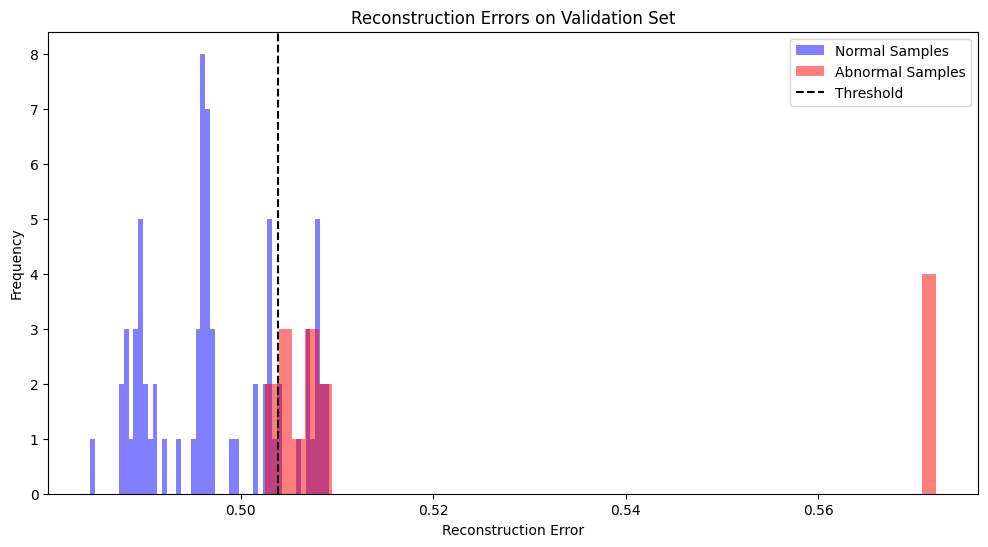

Best Threshold = 0.507634, Best F1 Score = 0.6364
Evaluation on Test Set:
Accuracy = 0.8160919540229885
Precision = 0.6086956521739131
Recall = 0.6666666666666666
F1 Score = 0.6363636363636365
Confusion Matrix:
 [[57  9]
 [ 7 14]]
Fold 4
Epoch 1/15, Loss: 1.186176
Epoch 2/15, Loss: 0.842525
Epoch 3/15, Loss: 0.600163
Epoch 4/15, Loss: 0.565443
Epoch 5/15, Loss: 0.560479
Epoch 6/15, Loss: 0.559321
Epoch 7/15, Loss: 0.558812
Epoch 8/15, Loss: 0.558294
Epoch 9/15, Loss: 0.557690
Epoch 10/15, Loss: 0.557448
Epoch 11/15, Loss: 0.557240
Epoch 12/15, Loss: 0.556776
Epoch 13/15, Loss: 0.556679
Epoch 14/15, Loss: 0.556869
Epoch 15/15, Loss: 0.556304
Best threshold: 0.5052186687185307, Best F1 Score: 0.8181818181818182


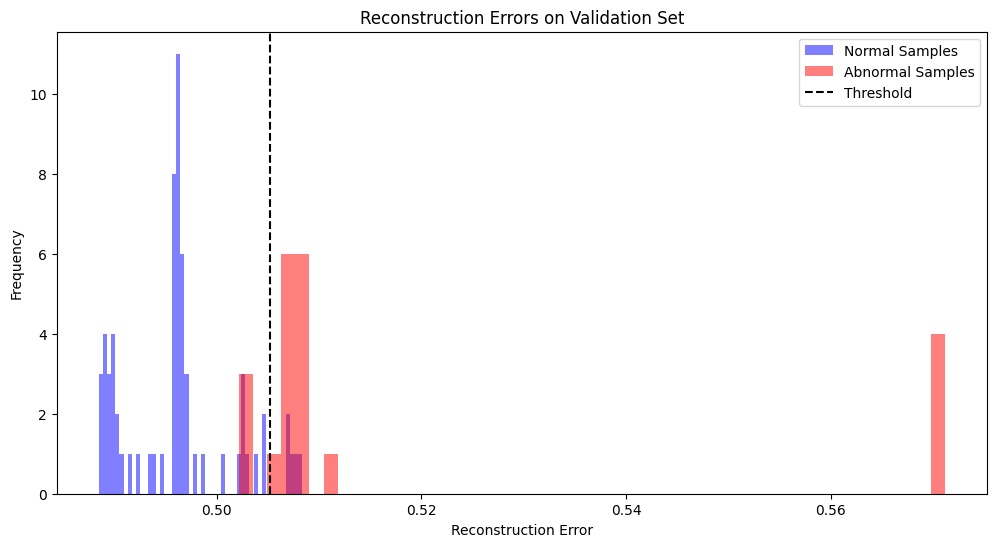

Best Threshold = 0.506881, Best F1 Score = 0.6486
Evaluation on Test Set:
Accuracy = 0.8505747126436781
Precision = 0.5454545454545454
Recall = 0.8
F1 Score = 0.6486486486486486
Confusion Matrix:
 [[62 10]
 [ 3 12]]
Fold 5
Epoch 1/15, Loss: 1.193802
Epoch 2/15, Loss: 0.853435
Epoch 3/15, Loss: 0.600057
Epoch 4/15, Loss: 0.564390
Epoch 5/15, Loss: 0.560529
Epoch 6/15, Loss: 0.559373
Epoch 7/15, Loss: 0.559188
Epoch 8/15, Loss: 0.558467
Epoch 9/15, Loss: 0.557742
Epoch 10/15, Loss: 0.557285
Epoch 11/15, Loss: 0.557361
Epoch 12/15, Loss: 0.556549
Epoch 13/15, Loss: 0.556762
Epoch 14/15, Loss: 0.556530
Epoch 15/15, Loss: 0.556375
Best threshold: 0.511780630458485, Best F1 Score: 0.7142857142857143


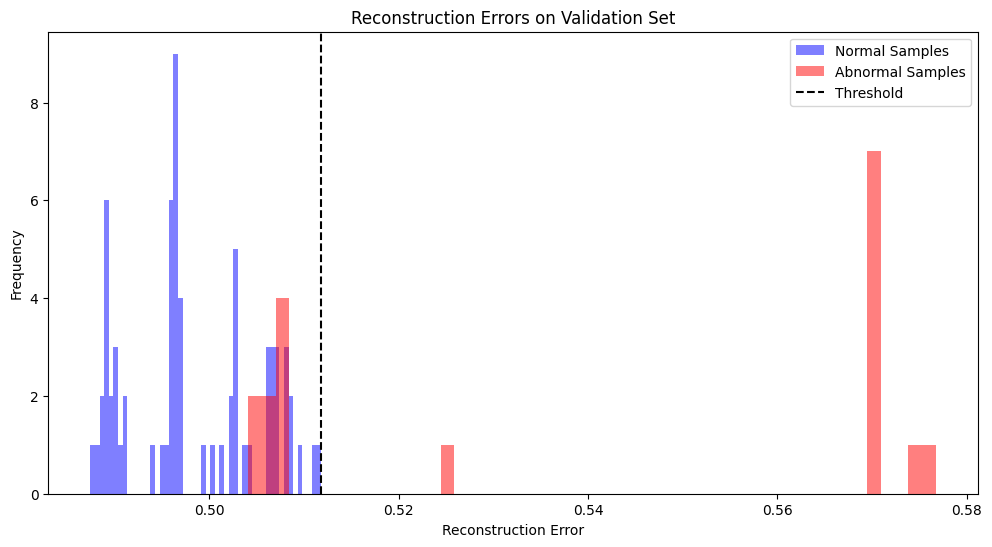

Best Threshold = 0.506965, Best F1 Score = 0.6818
Evaluation on Test Set:
Accuracy = 0.8390804597701149
Precision = 0.5769230769230769
Recall = 0.8333333333333334
F1 Score = 0.6818181818181818
Confusion Matrix:
 [[58 11]
 [ 3 15]]


In [15]:
acc = []
prec = []
rec = []
f1 = []
for fold, (train_idx, val_idx) in enumerate(skf.split(features_original, label)):
    
    print(f"Fold {fold + 1}")
    
   # Get full fold data
    fold_data, fold_labels = features_original[train_idx], label[train_idx]
    val_data, val_labels = features_original[val_idx], label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=np.random.randint(0, 1000))
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=np.random.randint(0, 1000))


    # Train autoencoder on the training fold
    model = train_autoencoder(features_normal, epochs=15, batch_size=64)

    # Add channel dimension to X_val
    X_val = X_val[:, np.newaxis, :]

    # Evaluate on validation fold
    val_normal = X_val[y_val == 0]
    val_abnormal = X_val[y_val == 1]
    val_errors_normal = compute_reconstruction_loss(model, val_normal)
    val_errors_abnormal = compute_reconstruction_loss(model, val_abnormal)
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    
    X_test = X_test[:, np.newaxis, :]  # Add channel dimension    
    val_errors_test = compute_reconstruction_loss(model, X_test)
    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)
    acc.append(accuracy_score(y_test, (val_errors_test > threshold).astype(int)))
    prec.append(precision_score(y_test, (val_errors_test > threshold).astype(int)))
    rec.append(recall_score(y_test, (val_errors_test > threshold).astype(int)))
    f1.append(f1_score(y_test, (val_errors_test > threshold).astype(int)))



In [16]:
np.mean(acc), np.mean(prec), np.mean(rec), np.mean(f1)

(0.7645506792058516,
 0.5308119658119658,
 0.7637593984962405,
 0.5731145210714577)

# Observation:



Average score:

Accuracy = 0.7645506792058516

Precision = 0.5308119658119658

Recall = 0.7637593984962405

F1 Score = 0.5731145210714577


Best:

Accuracy = 0.8977272727272727

Precision = 0.75

Recall = 0.7894736842105263

F1 Score = 0.7692307692307692

Confusion Matrix:

 [[64  5]

 [ 4 15]]